In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 1. 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNUSED>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


In [4]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 단, 모든 문장은 <BOS>로 시작. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [6]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
import numpy as np
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4. 모델 구성 및 validation set 구성

### 1) LSTM 모델

In [8]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수

model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(tf.keras.layers.LSTM(8))
model_1.add(tf.keras.layers.Dense(8, activation='relu'))
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 대략 1/3로 나눠지기 위해  train set(101182), val set(45000)으로 정하였다
X_val = X_train[:45000]   
y_val = y_train[:45000]

partial_X_train = X_train[45000:]  
partial_y_train = y_train[45000:]

print(X_val.shape)
print(y_val.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)

(45000, 41)
(45000,)
(101182, 41)
(101182,)


In [10]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10 

history = model_1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
198/198 [==============================] - 5s 8ms/step - loss: 0.5486 - accuracy: 0.7379 - val_loss: 0.4018 - val_accuracy: 0.8314
Epoch 2/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3557 - accuracy: 0.8530 - val_loss: 0.3505 - val_accuracy: 0.8496
Epoch 3/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3194 - accuracy: 0.8667 - val_loss: 0.3476 - val_accuracy: 0.8502
Epoch 4/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3015 - accuracy: 0.8756 - val_loss: 0.3488 - val_accuracy: 0.8512
Epoch 5/10
198/198 [==============================] - 1s 6ms/step - loss: 0.2893 - accuracy: 0.8818 - val_loss: 0.3522 - val_accuracy: 0.8494
Epoch 6/10
198/198 [==============================] - 1s 6ms/step - loss: 0.2780 - accuracy: 0.8874 - val_loss: 0.3566 - val_accuracy: 0.8507
Epoch 7/10
198/198 [==============================] - 1s 6ms/step - loss: 0.2666 - accuracy: 0.8930 - val_loss: 0.3636 - val_accuracy: 0.8475
Epoch 

In [11]:
results = model_1.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4044 - accuracy: 0.8399
[0.40438413619995117, 0.8399007320404053]


In [12]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


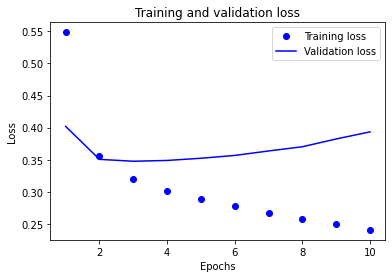

In [13]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

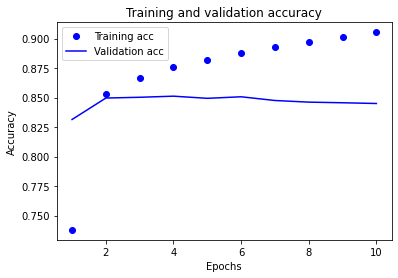

In [14]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 4. 학습된 Embedding 레이어 분석

In [15]:
embedding_layer = model_1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [16]:
import os

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [17]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['지루']
vector

array([-0.4913856 ,  0.15468393,  0.137691  , -0.13577399,  0.01035729,
        0.14501767, -0.45673418, -0.194047  , -0.12340724,  0.11523084,
       -0.15800294,  0.10638116, -0.05362372, -0.14107382,  0.14487956,
       -0.14236735], dtype=float32)

In [18]:
word_vectors.similar_by_word("지루")

[('별로', 0.9574987292289734),
 ('1', 0.9536287188529968),
 ('싫', 0.9477510452270508),
 ('재미없', 0.9469181299209595),
 ('욕', 0.9438011646270752),
 ('관가', 0.9427165389060974),
 ('실망', 0.941396951675415),
 ('고문', 0.9389563798904419),
 ('약하', 0.9373999238014221),
 ('멸망', 0.9330126643180847)]

### 2) Convolution Neural Network(1-D CNN)모델

In [19]:
vocab_size = 10000  
word_vector_dim = 16   

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.MaxPooling1D(5))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [20]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
198/198 [==============================] - 3s 6ms/step - loss: 0.5108 - accuracy: 0.7432 - val_loss: 0.3572 - val_accuracy: 0.8446
Epoch 2/10
198/198 [==============================] - 1s 5ms/step - loss: 0.3298 - accuracy: 0.8588 - val_loss: 0.3401 - val_accuracy: 0.8507
Epoch 3/10
198/198 [==============================] - 1s 5ms/step - loss: 0.2927 - accuracy: 0.8773 - val_loss: 0.3398 - val_accuracy: 0.8525
Epoch 4/10
198/198 [==============================] - 1s 5ms/step - loss: 0.2638 - accuracy: 0.8929 - val_loss: 0.3482 - val_accuracy: 0.8514
Epoch 5/10
198/198 [==============================] - 1s 5ms/step - loss: 0.2329 - accuracy: 0.9082 - val_loss: 0.3553 - val_accuracy: 0.8507
Epoch 6/10
198/198 [==============================] - 1s 5ms/step - loss: 0.1996 - accuracy: 0.9251 - val_loss: 0.3815 - val_accuracy: 0.8491
Epoch 7/10
198/198 [==============================] - 1s 5ms/step - loss: 0.1669 - accuracy: 0.9399 - val_loss: 0.4156 - val_accuracy: 0.8433
Epoch 

In [21]:
results = model_2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5747 - accuracy: 0.8282
[0.5747007727622986, 0.8281628489494324]


In [22]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


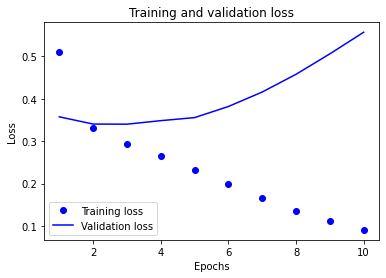

In [23]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

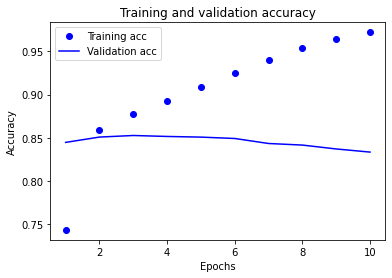

In [24]:
plt.clf()  

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 4. 학습된 Embedding 레이어 분석

In [25]:
embedding_layer = model_2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [26]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['지루']
vector

array([-0.01396566,  0.07248216,  0.20068118, -0.03973668,  0.06981758,
       -0.08252893, -0.05610181,  0.11596408,  0.01271981,  0.05280447,
       -0.06659499, -0.098772  , -0.05811134,  0.12422171,  0.2966578 ,
       -0.07819936], dtype=float32)

In [28]:
word_vectors.similar_by_word("지루")

[('하도', 0.9155529737472534),
 ('과한', 0.9136767387390137),
 ('막장', 0.9109800457954407),
 ('희생자', 0.8817278146743774),
 ('우베볼', 0.8816925883293152),
 ('사이코', 0.8812400698661804),
 ('폐지', 0.8792954683303833),
 ('구려', 0.8669778108596802),
 ('목적', 0.8621705174446106),
 ('흑역사', 0.8602960705757141)]

### 3) max pooling 모델

In [29]:
vocab_size = 10000 
word_vector_dim = 16

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history = model_3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
198/198 [==============================] - 1s 4ms/step - loss: 0.6193 - accuracy: 0.7428 - val_loss: 0.4987 - val_accuracy: 0.8119
Epoch 2/10
198/198 [==============================] - 1s 4ms/step - loss: 0.4184 - accuracy: 0.8292 - val_loss: 0.3784 - val_accuracy: 0.8349
Epoch 3/10
198/198 [==============================] - 1s 4ms/step - loss: 0.3439 - accuracy: 0.8557 - val_loss: 0.3562 - val_accuracy: 0.8434
Epoch 4/10
198/198 [==============================] - 1s 4ms/step - loss: 0.3094 - accuracy: 0.8717 - val_loss: 0.3510 - val_accuracy: 0.8461
Epoch 5/10
198/198 [==============================] - 1s 4ms/step - loss: 0.2852 - accuracy: 0.8834 - val_loss: 0.3529 - val_accuracy: 0.8465
Epoch 6/10
198/198 [==============================] - 1s 4ms/step - loss: 0.2660 - accuracy: 0.8926 - val_loss: 0.3587 - val_accuracy: 0.8464
Epoch 7/10
198/198 [==============================] - 1s 4ms/step - loss: 0.2497 - accuracy: 0.9006 - val_loss: 0.3661 - val_accuracy: 0.8461
Epoch 

In [31]:
results = model_3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4097 - accuracy: 0.8360
[0.4097215235233307, 0.8359541893005371]


In [32]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


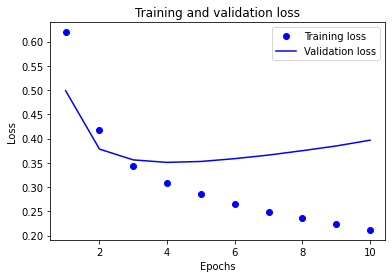

In [33]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

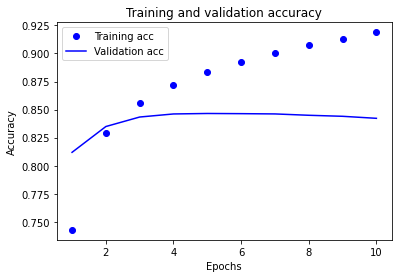

In [34]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 4. 학습된 Embedding 레이어 분석

In [35]:
embedding_layer = model_2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [36]:

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [37]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['지루']
vector

array([-0.01396566,  0.07248216,  0.20068118, -0.03973668,  0.06981758,
       -0.08252893, -0.05610181,  0.11596408,  0.01271981,  0.05280447,
       -0.06659499, -0.098772  , -0.05811134,  0.12422171,  0.2966578 ,
       -0.07819936], dtype=float32)

In [38]:
word_vectors.similar_by_word("지루")

[('하도', 0.9155529737472534),
 ('과한', 0.9136767387390137),
 ('막장', 0.9109800457954407),
 ('희생자', 0.8817278146743774),
 ('우베볼', 0.8816925883293152),
 ('사이코', 0.8812400698661804),
 ('폐지', 0.8792954683303833),
 ('구려', 0.8669778108596802),
 ('목적', 0.8621705174446106),
 ('흑역사', 0.8602960705757141)]

## 5. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [39]:
from gensim.models import KeyedVectors

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model' 

In [40]:
word_vectors.save('vectors.kv')
reloaded_word_vectors = KeyedVectors.load('vectors.kv')


In [41]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
print(word_vectors.wv["지루"])

[ 0.04174887 -0.21894366 -1.441043   -0.65588135  0.5381777  -0.24932627
 -1.2721392  -0.9349011  -0.99750704  0.29246134  1.3961207  -0.42496732
 -0.8030965  -0.01296767  2.397268    1.4943933  -0.32043195 -0.37196487
  0.63323635  1.3366741  -2.4578457   1.6403297   2.098323    0.6416305
  1.0303649   1.0531819   0.5380543   1.3501654   1.9899552  -0.078539
 -0.13185968 -0.5480784  -1.8893849  -0.9229791   0.4664928   1.3092248
 -2.2880766   0.37046084  1.2550128  -0.05545815  0.23954934 -0.93439806
 -0.6775805   2.4420333  -0.55737174 -0.81948894 -0.06877042 -1.2745227
  1.7742481   0.8814029  -0.33158144 -0.518086   -0.7392571  -0.62477165
  0.5336477  -1.080377    1.4759496  -0.56383216  1.0778964  -0.1535129
  0.28932756  0.0729184   0.5195994  -1.480617   -0.6663279  -0.8334627
  0.9109524  -0.9392463  -0.40699846 -0.38619068  3.2585053  -0.18726757
 -0.19806731 -1.2285595  -2.0928824   0.0425626   0.45743722  0.3735978
  0.1352734  -0.9122646   0.689723    0.56783    -0.257061 

In [42]:
print(word_vectors.wv.most_similar("지루"))

[('답답', 0.8431152105331421), ('불쾌', 0.8362601399421692), ('지저분', 0.8258276581764221), ('조용', 0.825817346572876), ('피곤', 0.817997932434082), ('쓸쓸', 0.8148923516273499), ('어색', 0.8136337995529175), ('침울', 0.8097155094146729), ('끔찍', 0.8070621490478516), ('씁쓸', 0.7979624271392822)]


In [43]:
vocab_size = 10000    
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

- 1. LSTM

In [44]:
from tensorflow.keras.initializers import Constant

#LSTM 모델 구성
model_4 = tf.keras.Sequential()
model_4.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))   
model_4.add(tf.keras.layers.LSTM(128))
model_4.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [45]:
# 학습의 진행
model_4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model_4.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
198/198 [==============================] - 4s 14ms/step - loss: 0.4828 - accuracy: 0.7644 - val_loss: 0.3999 - val_accuracy: 0.8213
Epoch 2/10
198/198 [==============================] - 2s 12ms/step - loss: 0.3665 - accuracy: 0.8372 - val_loss: 0.3559 - val_accuracy: 0.8424
Epoch 3/10
198/198 [==============================] - 2s 12ms/step - loss: 0.3130 - accuracy: 0.8658 - val_loss: 0.3318 - val_accuracy: 0.8556
Epoch 4/10
198/198 [==============================] - 2s 12ms/step - loss: 0.2791 - accuracy: 0.8825 - val_loss: 0.3322 - val_accuracy: 0.8550
Epoch 5/10
198/198 [==============================] - 2s 12ms/step - loss: 0.2493 - accuracy: 0.8979 - val_loss: 0.3439 - val_accuracy: 0.8558
Epoch 6/10
198/198 [==============================] - 2s 12ms/step - loss: 0.2253 - accuracy: 0.9084 - val_loss: 0.3398 - val_accuracy: 0.8596
Epoch 7/10
198/198 [==============================] - 2s 12ms/step - loss: 0.2009 - accuracy: 0.9192 - val_loss: 0.3534 - val_accuracy: 0.8579

In [46]:
results = model_4.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4368 - accuracy: 0.8530
[0.4368349313735962, 0.8529812693595886]


- Embedding

In [47]:
embedding_layer = model_4.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 100)


In [48]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_4.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [49]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['지루']
vector

array([-0.00310843,  0.07742301, -1.366329  , -0.7673046 ,  0.39787048,
       -0.22364111, -1.531175  , -0.6356377 , -0.7189394 ,  0.26457605,
        1.2589152 , -0.51672244, -0.720854  , -0.19235308,  2.464075  ,
        1.6239241 , -0.49560764, -0.04941995,  0.70682377,  1.3747616 ,
       -2.7966037 ,  1.4527912 ,  2.2193716 ,  0.8555854 ,  1.2991542 ,
        1.1922841 ,  1.0305068 ,  1.1868649 ,  2.1141305 ,  0.05337821,
        0.06840318, -1.0423282 , -1.7898978 , -1.245194  ,  0.39523348,
        1.5128658 , -2.1755733 ,  0.10212559,  1.4954551 ,  0.03450752,
        0.55616593, -1.046163  , -0.86785895,  2.6253357 , -0.5676749 ,
       -1.1693963 , -0.34151673, -1.5462908 ,  1.5184863 ,  1.0058168 ,
       -0.32360682, -0.838514  , -0.9801946 , -0.8562854 ,  0.96098506,
       -0.71271574,  1.319802  , -0.26413703,  1.4398873 ,  0.02627994,
        0.3088302 ,  0.35974732,  0.3696222 , -1.2680782 , -0.7418538 ,
       -1.0297962 ,  0.71637225, -0.8168384 , -0.3477774 , -0.11

In [50]:
word_vectors.similar_by_word("지루")

[('답답', 0.8382901549339294),
 ('불쾌', 0.8368010520935059),
 ('지저분', 0.8221735954284668),
 ('피곤', 0.8200621604919434),
 ('어색', 0.8118391036987305),
 ('끔찍', 0.8070061206817627),
 ('따분', 0.8053242564201355),
 ('조용', 0.7932084798812866),
 ('멍청', 0.7862249612808228),
 ('난잡', 0.776203453540802)]

- Convolution Neural Network(1-D CNN)

In [51]:
model_5 = tf.keras.Sequential()
model_5.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))
model_5.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_5.add(tf.keras.layers.MaxPooling1D(5))
model_5.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_5.add(tf.keras.layers.GlobalMaxPooling1D())
model_5.add(tf.keras.layers.Dense(8, activation='relu'))
model_5.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [52]:
model_5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history = model_5.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
198/198 [==============================] - 2s 7ms/step - loss: 0.6165 - accuracy: 0.6509 - val_loss: 0.5206 - val_accuracy: 0.7418
Epoch 2/10
198/198 [==============================] - 1s 6ms/step - loss: 0.4809 - accuracy: 0.7695 - val_loss: 0.4566 - val_accuracy: 0.7869
Epoch 3/10
198/198 [==============================] - 1s 5ms/step - loss: 0.4163 - accuracy: 0.8108 - val_loss: 0.4108 - val_accuracy: 0.8155
Epoch 4/10
198/198 [==============================] - 1s 5ms/step - loss: 0.3734 - accuracy: 0.8347 - val_loss: 0.3908 - val_accuracy: 0.8246
Epoch 5/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3424 - accuracy: 0.8520 - val_loss: 0.3761 - val_accuracy: 0.8348
Epoch 6/10
198/198 [==============================] - 1s 6ms/step - loss: 0.3181 - accuracy: 0.8641 - val_loss: 0.3702 - val_accuracy: 0.8354
Epoch 7/10
198/198 [==============================] - 1s 6ms/step - loss: 0.2981 - accuracy: 0.8754 - val_loss: 0.3760 - val_accuracy: 0.8356
Epoch 

In [53]:
results = model_5.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3943 - accuracy: 0.8388
[0.3942905068397522, 0.8388428688049316]


- Embedding

In [54]:
embedding_layer = model_5.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 100)


In [55]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_5.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [56]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['지루']
vector

array([-0.59175634,  0.3960097 , -0.51898545, -0.77226543, -0.08651378,
       -0.26186734, -1.577121  , -0.5066618 , -0.4797644 ,  0.530978  ,
        0.9809385 , -0.3390762 , -1.2690704 , -0.40388292,  2.6333919 ,
        1.8300421 , -0.566096  ,  0.2905173 ,  1.0797217 ,  1.3164665 ,
       -3.0303078 ,  1.0352309 ,  2.2757542 ,  1.1150153 ,  1.2425817 ,
        0.9217178 ,  1.044664  ,  1.5452728 ,  2.3878598 ,  0.62689835,
        0.4540304 , -0.7161259 , -1.3588253 , -1.2191105 , -0.01426057,
        1.889977  , -2.292082  ,  0.872336  ,  1.7718749 ,  0.3221965 ,
        0.8705197 , -1.4442248 , -1.2504245 ,  1.9328356 , -0.16793582,
       -1.0151545 , -0.5817698 , -1.832885  ,  1.1440148 ,  0.5428977 ,
       -0.80362   , -0.6510686 , -1.2107196 , -1.4658289 ,  0.7533136 ,
       -0.5366493 ,  0.9981011 , -0.05040126,  1.6425902 , -0.5773944 ,
        0.8200831 ,  0.62615114,  0.05186327, -1.091354  , -1.2312652 ,
       -0.7936414 ,  0.33885732, -1.0201186 , -0.71056396,  0.01

In [57]:
word_vectors.similar_by_word("지루")

[('불쾌', 0.8257558941841125),
 ('답답', 0.8241158723831177),
 ('지저분', 0.8190140724182129),
 ('어색', 0.8189951181411743),
 ('따분', 0.8009181618690491),
 ('피곤', 0.798170804977417),
 ('끔찍', 0.7923560738563538),
 ('멍청', 0.7863331437110901),
 ('난잡', 0.774083137512207),
 ('황당', 0.7664856910705566)]

- 3) Global max pooling 모델

In [58]:
model_6 = tf.keras.Sequential()
model_6.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))   
model_6.add(tf.keras.layers.GlobalMaxPooling1D())
model_6.add(tf.keras.layers.Dense(8, activation='relu'))
model_6.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [59]:
# 학습의 진행
model_6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history = model_6.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
198/198 [==============================] - 1s 5ms/step - loss: 0.7773 - accuracy: 0.5926 - val_loss: 0.6403 - val_accuracy: 0.6453
Epoch 2/10
198/198 [==============================] - 1s 4ms/step - loss: 0.6162 - accuracy: 0.6643 - val_loss: 0.5929 - val_accuracy: 0.6855
Epoch 3/10
198/198 [==============================] - 1s 4ms/step - loss: 0.5805 - accuracy: 0.6954 - val_loss: 0.5674 - val_accuracy: 0.7049
Epoch 4/10
198/198 [==============================] - 1s 4ms/step - loss: 0.5559 - accuracy: 0.7162 - val_loss: 0.5468 - val_accuracy: 0.7223
Epoch 5/10
198/198 [==============================] - 1s 4ms/step - loss: 0.5360 - accuracy: 0.7317 - val_loss: 0.5300 - val_accuracy: 0.7347
Epoch 6/10
198/198 [==============================] - 1s 4ms/step - loss: 0.5156 - accuracy: 0.7450 - val_loss: 0.5175 - val_accuracy: 0.7413
Epoch 7/10
198/198 [==============================] - 1s 4ms/step - loss: 0.5001 - accuracy: 0.7559 - val_loss: 0.5065 - val_accuracy: 0.7530
Epoch 

In [60]:
results = model_6.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4799 - accuracy: 0.7684
[0.47987765073776245, 0.7684358358383179]


- Embedding

In [61]:
embedding_layer = model_6.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 100)


In [62]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_6.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [63]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['지루']
vector

array([ 0.04174887, -0.21894366, -1.441043  , -0.65588135,  0.1705842 ,
       -0.24932627, -1.2721392 , -0.9349011 , -0.99750704,  0.518713  ,
        0.20770495, -0.42496732, -0.8030965 , -0.01296767,  3.0313516 ,
        2.0600898 , -0.32043195, -0.37196487,  0.50202405,  0.6240808 ,
       -2.4578457 ,  2.3329196 ,  1.4140528 ,  2.151828  ,  0.80680174,
        0.8919073 ,  0.5380543 ,  2.3933437 ,  2.4364617 , -0.078539  ,
       -0.13185968, -0.5480784 , -1.8893849 , -0.9229791 ,  0.4664928 ,
        0.8474095 , -2.2880766 ,  0.95001274,  0.47348168, -0.05545815,
        0.23954934, -0.93439806, -0.6775805 ,  2.8149493 , -0.55737174,
       -0.81948894, -0.06877042, -1.2745227 ,  1.2647594 ,  0.94900876,
       -0.33158144, -0.518086  , -0.7392571 , -0.62477165,  1.1190468 ,
       -1.080377  ,  0.8037875 , -0.56383216,  0.7976141 , -0.1535129 ,
        0.28932756,  0.0729184 , -0.23625635, -1.480617  , -0.6663279 ,
       -0.8334627 ,  0.46847564, -0.9392463 , -0.40699846, -0.38

In [64]:
word_vectors.similar_by_word("지루")

[('답답', 0.8253040909767151),
 ('지저분', 0.8160477876663208),
 ('어색', 0.8143982291221619),
 ('불쾌', 0.7929832339286804),
 ('피곤', 0.7847511768341064),
 ('멍청', 0.7789700031280518),
 ('따분', 0.774812638759613),
 ('조용', 0.7702121734619141),
 ('끔찍', 0.7661253213882446),
 ('예민', 0.7509320974349976)]

#### 리뷰 예측 해보기

In [65]:
Tokenizer = Mecab()

def sentiment_predict(new_sentence):
    new_sentence = tokenizer.morphs(new_sentence) # 토큰화
    new_sentence.insert(0, '<BOS>')
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    new_sentence = wordlist_to_indexlist(new_sentence) # encoding
    new_sentence = [new_sentence]

    new_sentence = tf.keras.preprocessing.sequence.pad_sequences(new_sentence,
                                                    value=word_to_index["<PAD>"],
                                                    padding='pre',
                                                    maxlen=maxlen)
    
    score = float(model_4.predict(new_sentence)) # 예측
    
    if score > 0.5:
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [66]:
def scores():
    text_arr = [
    '이건 신의 걸작이다 정말 재밌음.',
    '배우분들 연기는 좋아요~소재가 신박해서 봤는데 처음엔 픽픽 웃으며 재밌었으나 중반부턴 루즈한 감이,,,ㅠㅠㅠ',
    '시간아까워서 중간에나옴',
    '90년대식 전라도식 꼴통 무비 개핵노잼ㅜ',
    '어줍짢은 마블 영화보다 훨씬 재밌었음',
    '저예산 영화임에도 주인공들 연기가 넘 자연스럽고 음향.효과가 영화분위기 압도...사람과 사회에 대해 생각을 많이 하게 하는 작품이었습니다.',
    '일상생활에 있는 스토리로 스릴러를 만들어서 그런지 이입이 더 잘되었으며 오랜만에 긴장하면서 영화 본것같다.'
    ]
    
    for i in text_arr:
        print(i)
        score = sentiment_predict(i)
        print(score)
    
scores()

이건 신의 걸작이다 정말 재밌음.
99.77% 확률로 긍정 리뷰입니다.

None
배우분들 연기는 좋아요~소재가 신박해서 봤는데 처음엔 픽픽 웃으며 재밌었으나 중반부턴 루즈한 감이,,,ㅠㅠㅠ
97.83% 확률로 긍정 리뷰입니다.

None
시간아까워서 중간에나옴
100.00% 확률로 부정 리뷰입니다.

None
90년대식 전라도식 꼴통 무비 개핵노잼ㅜ
99.94% 확률로 부정 리뷰입니다.

None
어줍짢은 마블 영화보다 훨씬 재밌었음
99.26% 확률로 긍정 리뷰입니다.

None
저예산 영화임에도 주인공들 연기가 넘 자연스럽고 음향.효과가 영화분위기 압도...사람과 사회에 대해 생각을 많이 하게 하는 작품이었습니다.
99.99% 확률로 긍정 리뷰입니다.

None
일상생활에 있는 스토리로 스릴러를 만들어서 그런지 이입이 더 잘되었으며 오랜만에 긴장하면서 영화 본것같다.
99.91% 확률로 긍정 리뷰입니다.

None


## 회고

- 어려웠던 점 : 한국어 Word2Vec 임베딩 활용하여 성능 개선을 했을때 처음 설정하는 법이 어려웠다.
- 알아낸 점 및 모호한 점 : 사전에 학습된 한국어 embedding 한 결과가 '지루' 라는 단어에 더 유사성이 있는 결과가 나왔다. 결과적으로 한국어 Word2Vec을 하기 전에는 정확도가 85%가 넘지 않았는데, 하고나서 LSTM만 정확도가 85%을 넘었다.
- 노력한 점 : epoch에 따라 정확도가 달라져서 최대한 정확도를 높게 받을 수 있도록 찾아봤다. 
- 자기다짐 : 주로 리뷰 긍정, 부정 예측하는데 있어서 토큰화를 하는 과정을 자세히 알아야 겠다. model의 shape을 설정하는 것을 조금 더 공부해야겠다.